In [157]:
import gymnasium as gym
import torch
from src.data.services.dimensions import get_dims

In [158]:
env_name = "MountainCar-v0"

In [159]:
env = gym.make(env_name)

In [160]:
from src.nn.services.dqn import DQN

In [161]:
state_dim, action_dim = get_dims(env)

In [162]:
dqn = DQN(state_dim, action_dim)

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
dqn = dqn.to(device)

In [165]:
from src.training.services.train import full_training as train

In [166]:
from src.data.services.memory import ReplayMemory

In [167]:
rm = ReplayMemory(10000)

In [168]:
target_net = DQN(state_dim, action_dim)

In [169]:
target_net.load_state_dict(dqn.state_dict())

<All keys matched successfully>

In [170]:
target_net = target_net.to(device)

In [171]:
from torch.optim import Adam

In [172]:
optm = Adam(dqn.parameters(), lr=0.001)

In [173]:
batch_size = 64
gamma = 0.99
num_episodes = 10000
target_update = 50
epsilon = 0.25

In [174]:
import cv2

In [175]:
def create_video(frames, fps=10, output_name="output"):
    out = cv2.VideoWriter(f"{output_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        out.write(frame)
    out.release()

In [176]:
from src.policy.services.epsilon_greedy import epsilon_greedy

In [177]:
def test_dqn(dqn, env, device, output_name="output"):
    frames = []
    rewards = []
    state, _ = env.reset()
    done = False
    while not done:
        frames.append(env.render())
        action = epsilon_greedy(
            torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device), dqn, 0)
        next_state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        done = terminated or truncated
        state = next_state
    create_video(frames, output_name=output_name)
    return rewards

In [178]:
bf_rewards = test_dqn(dqn, gym.make(env_name, render_mode="rgb_array"), device, output_name="before_training_mountain_car")

In [179]:
pretrain_path = "./src/pretrain/data/MountainCar-v0_10_000.npy"
pretrain_epochs = 100
pretrain_batch_size = batch_size
pretrain_optimizer = optm

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

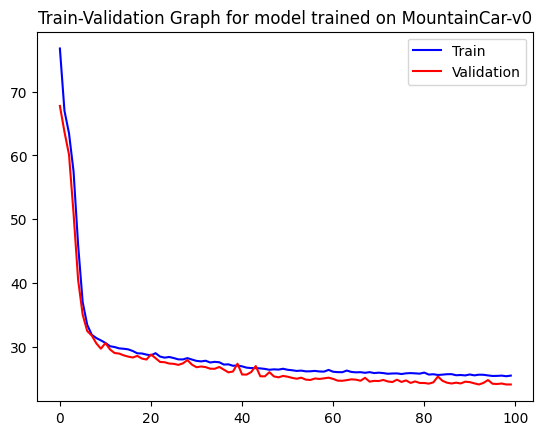

In [180]:
train(
    pretrain_path,
    pretrain_epochs,
    pretrain_batch_size,
    pretrain_optimizer,
    env,
    rm,
    dqn,
    target_net,
    optm,
    batch_size,
    gamma,
    device,
    200,
    epsilon,
    target_update,
    pretrain_done_callback=lambda dqn: test_dqn(dqn, gym.make(env_name, render_mode="rgb_array"), device, output_name="pretrain_mountain_car"),
)

In [181]:
af_rewards = test_dqn(dqn, gym.make(env_name, render_mode="rgb_array"), device, output_name="after_training_mountain_car")